# Deep image prior
inpainting 문제에 대해 코드를 일부 customize 해보았습니다.

# Import libraries
먼저, 구글 드라이브와 Colab을 연동하기 위해 권한을 획득해줍니다.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###파일 읽기/저장 경로 설정하기
다른 path에 있는 코드들을 사용할 수 있도록 절대경로를 설정해 주어야 합니다.

사람마다 파일 경로가 다르기 때문에 따로 설정해 주어야 합니다
이 노트가 저장되어 있는 폴더의 주소를 가져와 주세요

In [0]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/deep-image-prior')
os.getcwd() # check current directory

'/content/drive/My Drive/Colab Notebooks/deep-image-prior'

영상을 띄울 수 있는 matplotlib와 torch 등의 라이브러리를 가져오고

>matplotlib, numpy, torch

다음과 같은 내용들을 import시켜줍니다.

CNN 모델들:
> ResNet, UNet

이미지를 불러오고 numpy 데이터로 변형 시켜주는 함수:
> from utils.inpainting_utils import *

*(원본 이미지와 mask를 생성하고 numpy데이터로 변형하는 것을 도와준다)*

In [0]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 64

### 그림판 생성 함수
**custom mask**를 만들 수 있는 환경을 제공하는 코드를 추가해 보았습니다.

`draw()`로 언제든지 불러서 사용할 수 있습니다

In [0]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<canvas width=%d height=%d style="background-image:url('%s')"></canvas>
<br>
<br>
<div class="slidecontainer" style="border-style: solid;
  border-width: 1px; width: 200px">
  Brush Size: <input type="range" min="1" max="30" value="5" class="slider" id="myRange">
 <span id="demo"></span>
</div>
<br>
<button style="
  background-color: #008CBA; 
  border: none; 
  color: white;
  padding: 15px 32px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;"
}>Finish</button>
<script>
var slider = document.getElementById("myRange")
var output = document.getElementById("demo")
output.innerHTML = slider.value

slider.oninput = function() {
  output.innerHTML = this.value
  ctx.lineWidth = this.value
}

var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = 5
ctx.lineJoin = 'round'
ctx.lineCap = 'round'
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

# saves the result in 'data' file as name: 'customMask.png'
def draw(filename='data/customMask.jpeg  ', w=400, h=200, backgroundImg=''):
  display(HTML(canvas_html % (w, h, backgroundImg)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

# 파일 선택
드라이브에 있는 이미지 파일의 경로를 지정합니다

img_path 변수에 string으로 경로를 저장하면 됩니다

In [0]:
## Fig 6
# img_path  = 'data/inpainting/vase.png'
# mask_path = 'data/inpainting/vase_mask.png'

# # Fig 8
# img_path  = 'data/inpainting/library.png'
# mask_path = 'data/inpainting/library_mask.png'

img_path  = 'data/handong_sky.jpeg'
# mask_path = 'data/handong_sky_mask.jpeg'

  # ## Fig 7 (top)
  # img_path  = 'data/inpainting/kate.png'
  # mask_path = 'data/inpainting/kate_mask.png'

# Another text inpainting example
# img_path  = 'data/inpainting/peppers.png'
# mask_path = 'data/inpainting/peppers_mask.png'

mask_path = 'data/customMask.jpeg  ' #custom mask path

NET_TYPE = 'skip_depth6' # one of skip_depth4|skip_depth2|UNET|ResNet

### 이미지 가져오기
이미지를 실제로 가져오는 단계입니다.
crop_image함수를 통해 이미지를 center crop시켜준 후, PIL 형식인 이미지를 np.array로 변환시켜줍니다.

이미지를 CNN에 넣기 쉽게 dim_div_by에서 지정한 수로 나누어 떨어지는 크기로 맞춰줍니다.

In [0]:
img_pil, img_np = get_image(img_path, imsize)


In [0]:
img_pil      = crop_image(img_pil,      dim_div_by)

img_np      = pil_to_np(img_pil)

## Mask 그리기
그림판에서 mask를 직접 그려서 원본 이미지에서 원하는 부분에 mask를 씌울 수 있습니다.

mask가 씌워진 부분의 이미지 내용을 프로그램이 스스로 제작 할 것입니다

In [0]:
# mask를 직접 그리기 쉽게 도와주기 위해 그림판의 배경을 원본 이미지로 지정하게 만들었다
# 원본 사진을 base64로 변경하여 background image로 설정하면 된다
import base64
from io import BytesIO

buffered = BytesIO()
bgImage = img_pil.copy()
bgImage = bgImage.convert("RGB") # get rid of alpha channel
bgImage.save(buffered, format="JPEG")
img_str = base64.b64encode(buffered.getvalue())
img_base64 = str(bytes("data:image/jpeg;base64,", encoding='utf-8') + img_str).lstrip('b').strip("'")


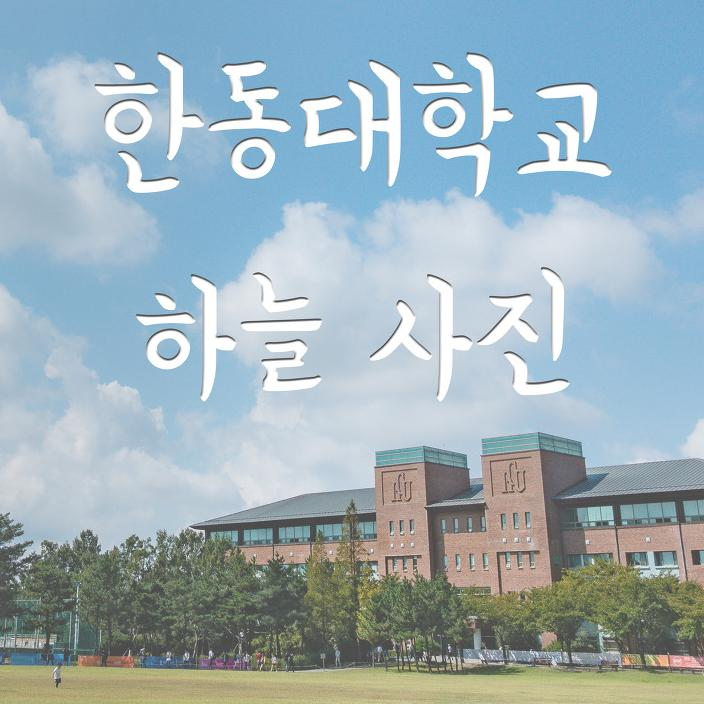

26625

In [0]:
draw(w=img_pil.size[0], h=img_pil.size[1], backgroundImg=img_base64)
#글씨 같은 것은 지우기를 원하는 부분을 완벽하게 다 가려야 원하는 결과가 나온다
# brush를 크게해서 조금 오버하더라도 확실하게 다 가리는 것이 좋다

# 위 함수는 Finish 버튼을 클릭하면 mask를 data에 'custom_mask'라는 이름으로 이미지 형식으로 저장한다

# cumtom mask 불러오기
위에서 제작하여 저장한 mask파일을 불러옵니다

In [0]:
img_mask_pil, img_mask_np = get_image(mask_path, imsize)

In [0]:
# transparent한 부분이 RGB로 표시될 때 검정색으로 보이는 문제 해결
from PIL import Image

image = Image.new("RGB", img_mask_pil.size, "WHITE")
image.paste(img_mask_pil, (0, 0), img_mask_pil) 
img_mask_pil = image

### Center crop

불러온 이미지를 CNN에 집어넣을 수 있도록 크기에 맞게 자릅니다

이것 또한 dim_div_by로 나누어 떨어지는 크기로 자릅니다



In [0]:
img_mask_pil = crop_image(img_mask_pil, dim_div_by)

img_mask_np = pil_to_np(img_mask_pil)

### 시각화

원본 이미지 / mask 이미지 / 원본 이미지 위에 마스크를 덮어 씌운 이미지를 비교할 수 있도록 가져옵니다.

이렇게 원본영상과 마스크 영상을 가져오고 두 영상을 합쳐, unclean한 영상을 만들어줍니다. 학습에는 clean한 target 데이터 설정 없이, 합성된 영상(3번째 영상)만 input으로 들어가게 됩니다.

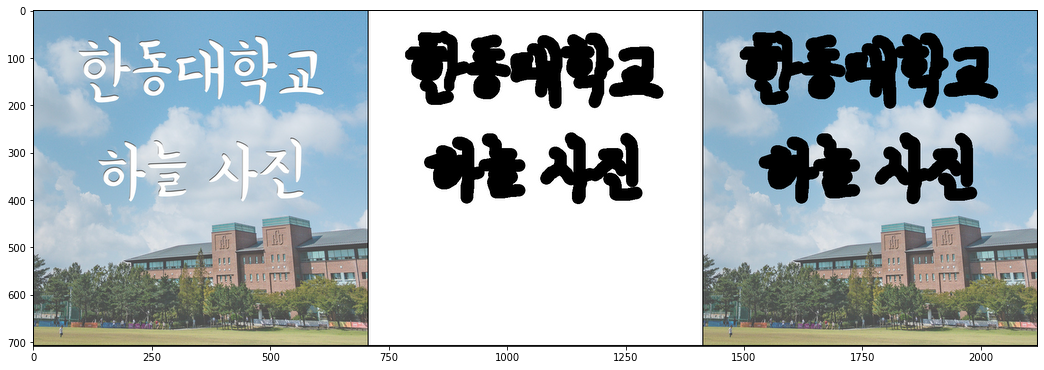

In [0]:
img_mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np*img_np], 3,15);

# 설정
학습에 앞서 필요한 환경들을 설정 해줍니다.
optimizer, iteration 횟수, activation function 등과 같은 파라미터들을 설정해줍니다. deep image prior는 이미지 자체 이외의 사전 training 없이 이미지를 개선시키기 때문에, 각각의 영상에 대해 최적의 결과로 이끌기 위해서 조금씩 다른 구성의 파라미터들을 갖게 됩니다.





In [0]:
pad = 'reflection' # 'zero'
OPT_OVER = 'net'
OPTIMIZER = 'adam'

In [0]:
if 'vase.png' in img_path:
    INPUT = 'meshgrid'
    input_depth = 2
    LR = 0.01 
    num_iter = 5001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up   = [128] * 5,
               num_channels_skip = [0] * 5,  
               upsample_mode='nearest', filter_skip_size=1, filter_size_up=3, filter_size_down=3,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif ('kate.png' in img_path) or ('peppers.png' in img_path):
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise' 
    input_depth = 32
    LR = 0.01 
    num_iter = 6001
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

elif 'handong_sky.jpeg' in img_path:
    # Same params and net as in super-resolution and denoising
    INPUT = 'noise' 
    input_depth = 32
    LR = 0.01 
    num_iter = 3801
    param_noise = False
    show_every = 50
    figsize = 5
    reg_noise_std = 0.03
    
    net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [128] * 5,
               num_channels_up =   [128] * 5,
               num_channels_skip =    [128] * 5,  
               filter_size_up = 3, filter_size_down = 3, 
               upsample_mode='nearest', filter_skip_size=1,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
    
elif 'library.png' in img_path:
    
    INPUT = 'noise'
    input_depth = 1
    
    num_iter = 3001
    show_every = 50
    figsize = 8
    reg_noise_std = 0.00
    param_noise = True
    
    if 'skip' in NET_TYPE:
        
        depth = int(NET_TYPE[-1])
        net = skip(input_depth, img_np.shape[0], 
               num_channels_down = [16, 32, 64, 128, 128, 128][:depth],
               num_channels_up =   [16, 32, 64, 128, 128, 128][:depth],
               num_channels_skip =    [0, 0, 0, 0, 0, 0][:depth],  
               filter_size_up = 3,filter_size_down = 5,  filter_skip_size=1,
               upsample_mode='nearest', # downsample_mode='avg',
               need1x1_up=False,
               need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
        
        LR = 0.01 
        
    elif NET_TYPE == 'UNET':
        
        net = UNet(num_input_channels=input_depth, num_output_channels=3, 
                   feature_scale=8, more_layers=1, 
                   concat_x=False, upsample_mode='deconv', 
                   pad='zero', norm_layer=torch.nn.InstanceNorm2d, need_sigmoid=True, need_bias=True)
        
        LR = 0.001
        param_noise = False
        
    elif NET_TYPE == 'ResNet':
        
        net = ResNet(input_depth, img_np.shape[0], 8, 32, need_sigmoid=True, act_fun='LeakyReLU')
        
        LR = 0.001
        param_noise = False
        
    else:
        assert False
else:
    assert False

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype)

In [0]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var = np_to_torch(img_np).type(dtype)
mask_var = np_to_torch(img_mask_np).type(dtype)

Number of params: 3002627


# Main loop
이제 반복하여 optimize시키면서 영상을 복원되는 모습을 확인할 수 있습니다.

In [0]:
i = 0
def closure():
    
    global i
    
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
   
    total_loss = mse(out * mask_var, img_var * mask_var)
    total_loss.backward()
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Output hidden; open in https://colab.research.google.com to view.

# 결과
끝으로 복원된 결과 영상을 가져와서 띄우고,
numpy형태를 다시 plot으로 변환해 사진을 저장시키는 부분을 코드로 추가해보았습니다. 

결과적으로 합성시켰던 mask부분의 이미지가 제거되고 주변과 어울리는 자연스러운 모습으로 대체 된 모습을 확인할 수 있습니다.

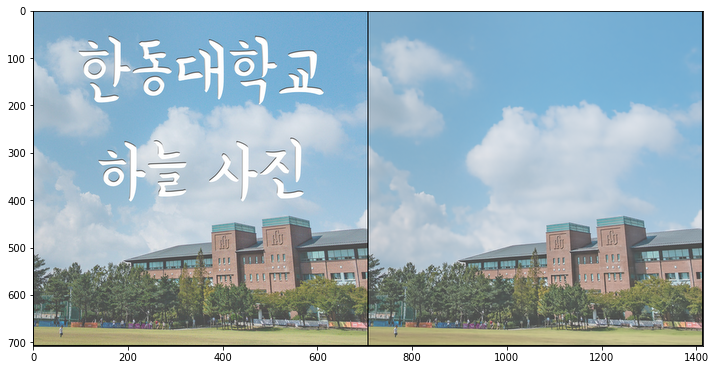

In [0]:
from PIL import Image

out_np = torch_to_np(net(net_input))
plot_image_grid([img_np, out_np], factor=10);

#save result
tensor_to_plot = torch.from_numpy(out_np)
torchvision.utils.save_image(tensor_to_plot, "data/inpainting_result3.png")

# 결론
먼저 원본 영상과 3개의 결과 영상을 보여드리겠습니다.

<br>

## *원본 영상*
![alt text](https://drive.google.com/uc?export=view&id=1N2ExGCK02aXbNABiV47ZDmrJfjEIxsqg)


## *결과 1*
![alt text](https://drive.google.com/uc?export=view&id=1--qPohH6Pm3gpjb_j04WpcseeXDgiNdz)


## *결과 2*
![alt text](https://drive.google.com/uc?export=view&id=1gnlwuIsZCXtTBuKQI428hRPaduYClx2f)


## *결과 3*
![alt text](https://drive.google.com/uc?export=view&id=1-9DkKdxNm5llk8O-7x1ykHzBgNaSu3I3)

<br>

각 결과를 만들어 낸 설정:
* 결과1: kate 이미지와 같은 설정
* 결과2: kate 이미지와 같은 설정이지만 iteration(`num_iter`)을 3801으로 설정
* 결과2: 결과2와 같은 설정

<br>

**장점**: 결과3과 같이 원본의 화질을 유지하면서 원하는 부분을 없애고 자연스럽게 만들 수 있었습니다.

**단점**: 이미지의 크기가 클수록 시간이 오래 걸렸습니다. 우리가 예시로 사용한 이미지는 크기로 3801번 반복하는데 구글 코랩 GPU 환경에서 약 1시간 30분이 걸렸습니다.

또한 처음에 랜덤한 CNN 값으로 시작해서인지 2번째 결과와 같이 자연스럽지 않은 부분이 생성되기도 하였습니다.

결과1은 너무 많이 반복하여 overfit과 같은 현상으로 인해 이미지가 이상해 졌다고 생각합니다. 좋은 결과를 얻기 위해서는 각 이미지 마다 최적의 설정을 실험해 봐야 합니다.

<br>

결과적으로 원하는 결과를 얻을 수 있어서 좋았고, 데이터를 사용한 사전 훈련 없이도 CNN 뉴론 네크워크 자체만으로도 자연스러운 이미지의 특성을 잡아내서 이미지 복원(inpainting)과 같은 분야에서 좋은 퀄리티의 결과를 낼 수 있다는 것을 배울 수 있었습니다.


원본 영상            |  결과 3
:------------------------------:|:------------------------------:
![](https://drive.google.com/uc?export=view&id=1N2ExGCK02aXbNABiV47ZDmrJfjEIxsqg)  |  ![](https://drive.google.com/uc?export=view&id=1-9DkKdxNm5llk8O-7x1ykHzBgNaSu3I3)